In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime as dt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import urllib.request
import os
import keras
from keras.models import load_model
import pandas as pd

### DATA SOURCES

35000 stations worldwide: [AWS](https://registry.opendata.aws/noaa-isd/)

Precipitation: [GES DISC](https://daac.gsfc.nasa.gov/datasets/GPM_3IMERGDF_06/summary?keywords=precipitation)

Predicted Temp., Wind Vel., Rel. Hum.: [GFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast) found through [earth github](https://github.com/cambecc/earth)

In [11]:
# latitude, longitude
lat = (90, -90)
lon = (0, 360)

# Ontario limits
ont_limits = (360 - 95, 360 - 74, 41, 60)

# Load in the model
ths_keras_model = load_model('models' + os.sep + 'ths1_val-loss_9.3.keras')


In [33]:
today = dt.date.today().strftime("%Y%m%d")

#url = f'https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f000'
#filepath = f'data/pred_{date}_{step}'

def get_GFS_prediction(lat, lon, date=today, step='f000', hour=0):
    # step : 'anl' or 'fFFF' where FFF is in 000-384
    # hour : 0, 6, 12, 18
    
    # get correct url in NOAA GFS 
    res = '0p25'  # 0.25 degrees precision
    gfs = f'https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod'
    url = f'{gfs}/gfs.{date}/{hour:02d}/atmos/gfs.t{hour:02d}z.pgrb2.{res}.{step}'
    print(url)
    
    # download data to filepath 
    filepath = f'data' + os.sep + 'gfs' + os.sep + f'gfs_{date}_{step}'
    urllib.request.urlretrieve(url, filepath)
    
    # types of data we want from GFS
    kwargs_2m = {'filter_by_keys' : {'typeOfLevel' : 'heightAboveGround',
                                    'level' : 2}
             }
    kwargs_surf = {'filter_by_keys' : {'typeOfLevel' : 'surface'}}
    
    if step != 'f00':
        kwargs_surf = {'filter_by_keys' : {'stepType': 'instant',
                                           'typeOfLevel' : 'surface'}}
    
    # put data in easy to use arrays
    
    with xr.open_dataset(filepath,
                     engine='cfgrib',
                     backend_kwargs=kwargs_2m) as ds:

        temp = ds['t2m'].sel(latitude = slice(*lat), longitude = slice(*lon))
        relh = ds['r2'].sel(latitude = slice(*lat), longitude = slice(*lon))
        
        # this downloads and converts temperature and relative humidity data 2 
        # meters above the ground
        lons = temp.longitude.data
        lats = temp.latitude.data
        data_temp = temp.data - 273.15  # Kelvin to Celsius
        data_relh = relh.data           # in %

    with xr.open_dataset(filepath,
                        engine='cfgrib',
                        backend_kwargs=kwargs_surf) as ds:

        gust = ds['gust'].sel(latitude = slice(*lat), longitude = slice(*lon))
        
        # surface gust data
        data_gust = gust.data * 3.6  # km / h
        
    return lons, lats, data_temp, data_relh, data_gust
    

### Create a map

In [30]:
def create_world_map(map,
                     data,
                     land_map,
                     savefile,
                     lons,
                     lats,
                     title,
                     figsize=(20,12),
                     colormap='viridis',
                     minmax=None,
                     limits=None):
    
    plt.figure(figsize=figsize)

    # map lon-lat to map coordinates
    lon2d, lat2d = np.meshgrid(lons, lats)
    x, y = map(lon2d, lat2d)

    # plot coastlines
    map.drawcoastlines()

    # plot color scale
    cs = map.pcolor(x, y,  np.ma.masked_where(land_map == False, data))
    
    # change min/max of data
    if minmax:
        cs = map.pcolor(x, y, np.ma.masked_where(land_map == False, data),
                        vmin=minmax[0],
                        vmax=minmax[1],
                        cmap=colormap)
    
    else:
        cs = map.pcolor(x, y, np.ma.masked_where(land_map == False, data),
                        cmap=colormap)
        
    # change dimensions of figure
    if limits:
        xmin, ymin = map(limits[0], limits[2])
        xmax, ymax = map(limits[1], limits[3])
        
        ax = plt.gca()

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
    
    # colorbar
    cbar = map.colorbar(cs, location='bottom', pad="10%", label=title)
    plt.savefig('figures' + os.sep + savefile)

In [27]:
def write_csv_meteo(data_temp, data_relh, data_gust, step, lons, lats, date=today):
    filename = f"gfs_{date}_{step}_ths.csv"
    with open("data" + os.sep + 'gfs' + os.sep + filename, 'w', newline='') as file:
        # write function
        writer = csv.writer(file)
        
        # create row to define variables
        writer.writerow(["lon", "lat", "t", "h", "p", "s"])
        
        for i, lat_i in enumerate(lats):
            for j, lon_j in enumerate(lons):
                writer.writerow([lon_j,
                                lat_i,
                                data_temp[i, j],
                                data_relh[i, j],
                                0.0,
                                data_gust[i, j]])
    return filename

In [29]:
def read_fwi_csv(lats, lons, fwi_csv_filename):
    with open('data' + os.sep + 'gfs' + os.sep + fwi_csv_filename, newline='') as csvfile:
        fwi_ths = list(csv.reader(csvfile))
        
        fwi_ths.pop(0)

        fwi_ths_2D = np.zeros((len(lats), len(lons)))

        lats_dict = {f'{k}': v for v, k in enumerate(lats)}
        lons_dict = {f'{k}': v for v, k in enumerate(lons)}

        for point in fwi_ths:
            idx_lat = lats_dict[point[2]]
            idx_lon = lons_dict[point[1]]
            fwi_ths_2D[idx_lat][idx_lon] = point[7]
        
    return fwi_ths_2D

### Todays Predictions

In [16]:
# Today's GFS prediction
lons, lats, data_temp, data_relh, data_gust = get_GFS_prediction(lat, lon)
today_GFS_csv = write_csv_meteo(data_temp, data_relh, data_gust, 'f000', lons, lats)

https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f000


#### Calculate FWI

In [17]:
# Load in the global weather data ths
df = pd.read_csv('data' + os.sep + today_GFS_csv)

# get the predictor features
pred_features = df[['t','h','s']].to_numpy()

#Predict labels
pred_labels = ths_keras_model.predict(pred_features)

#Assign labels to the DF
df['fwi_ths'] = pred_labels
fwi_csv_filename = today_GFS_csv[:-4] + '_fwi.csv'
df.to_csv('data' + os.sep + fwi_csv_filename)

data_fwi = read_fwi_csv(lats, lons, fwi_csv_filename)

32445/32445 [==============================] - 45s 1ms/step


#### Plot maps

In [18]:
# basemap creating
m = Basemap(lon_0=180)

# create land map for only plotting fwi on land
land_map = np.zeros((len(lats), len(lons)))

for i, lat_i in enumerate(lats):
    for j, lon_j in enumerate(lons):
        land_map[i, j] = m.is_land(lon_j, lat_i)

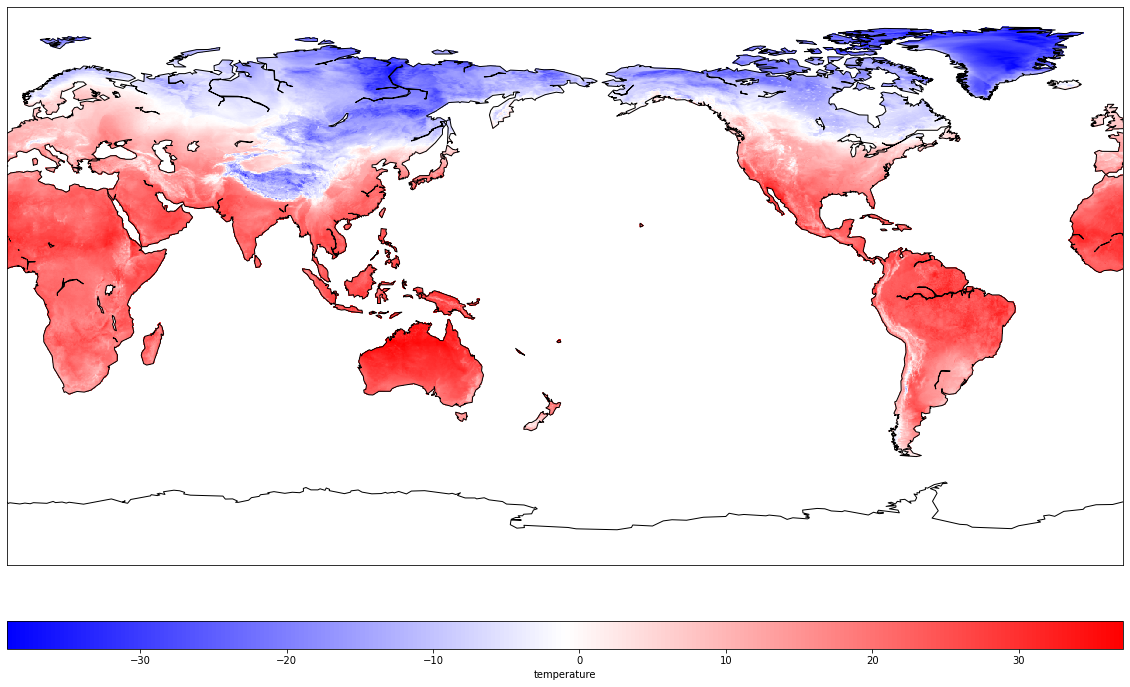

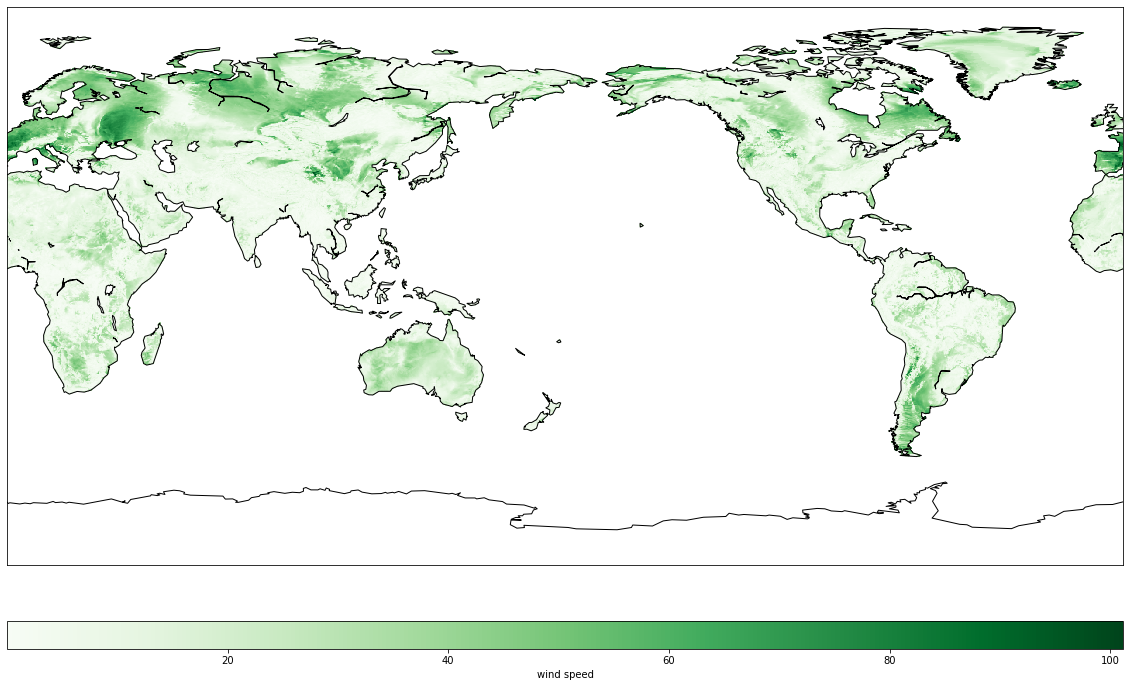

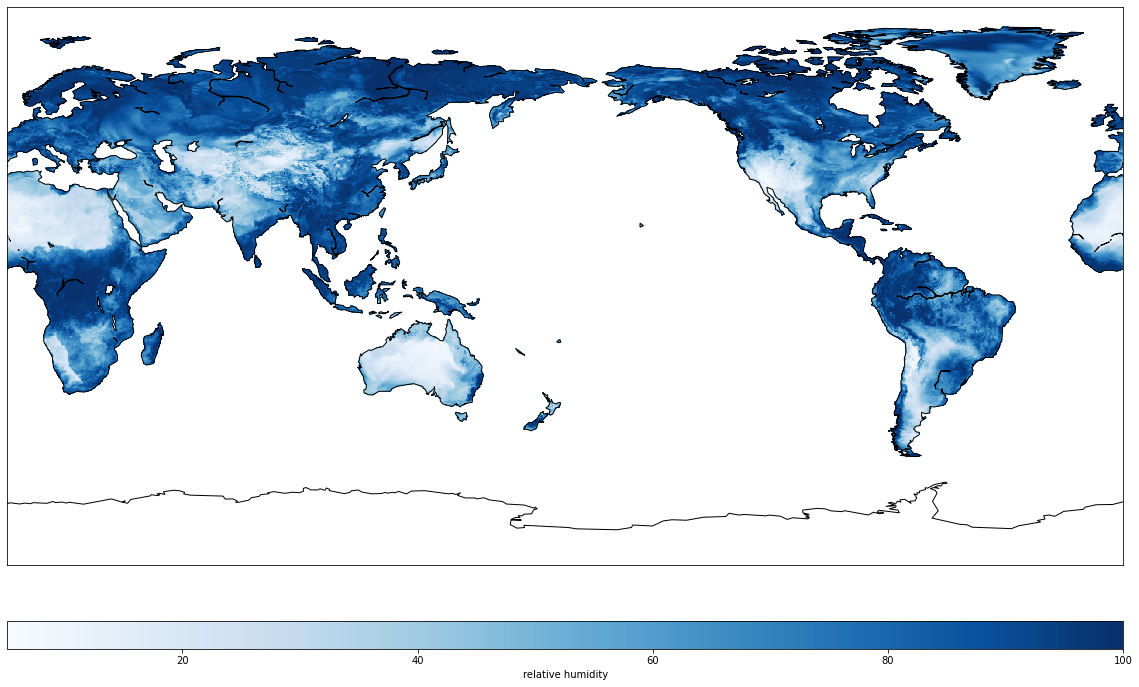

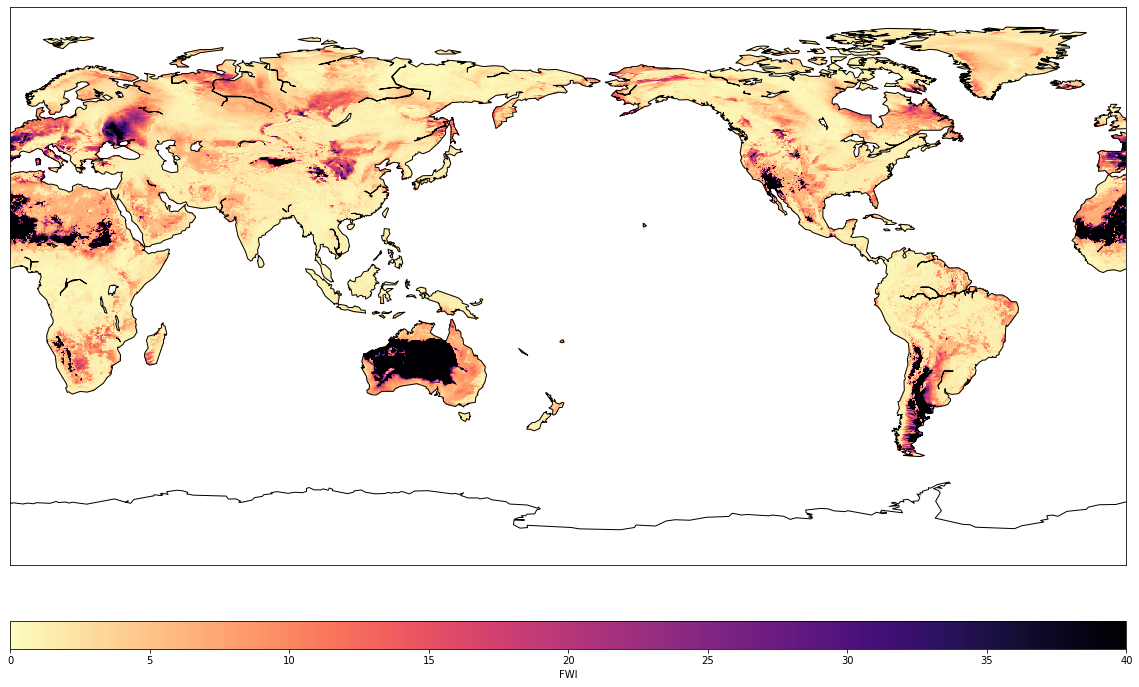

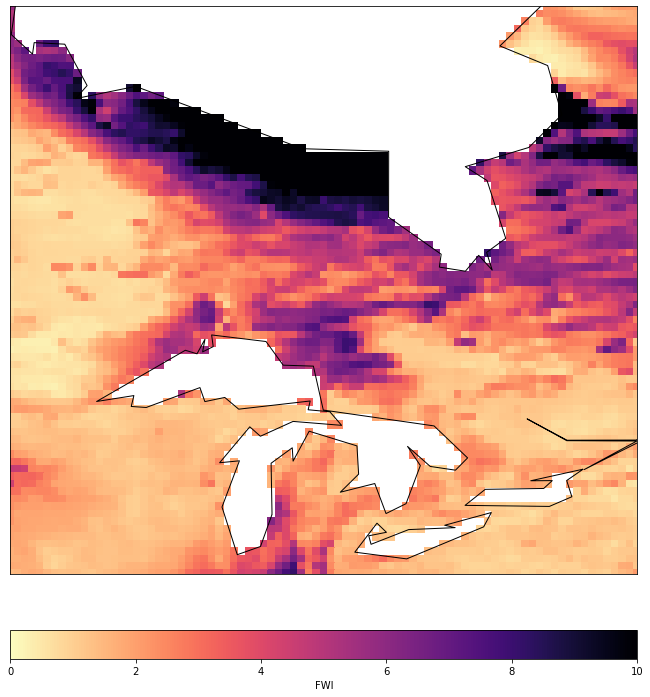

In [20]:
savefile = f'temp_{today}.png'
create_world_map(m, data_temp, land_map, savefile, lons, lats, 'temperature', figsize=(20,12), colormap='bwr', minmax=None, limits=None)

savefile = f'wind_{today}.png'
create_world_map(m, data_gust, land_map, savefile, lons, lats, 'wind speed', figsize=(20,12), colormap='Greens', minmax=None, limits=None)

savefile = f'rh_{today}.png'
create_world_map(m, data_relh, land_map, savefile, lons, lats, 'relative humidity', figsize=(20,12), colormap='Blues', minmax=None, limits=None)

savefile = f'fwi_{today}.png'
create_world_map(m, data_fwi, land_map, savefile, lons, lats, 'FWI', figsize=(20,12), colormap='magma_r', minmax=(0, 40), limits=None)

savefile = f'fwi_ontario_{today}_f000.png'
create_world_map(m,
                data_fwi,
                land_map,
                savefile,
                lons,
                lats,
                'FWI',
                figsize=(12,12),
                colormap='magma_r',
                minmax=(0, 10),
                limits=ont_limits)

### Forecasting 16 days Ontario

In [34]:
# long term prediction for 16 days
for i in np.linspace(24, 384, 16, dtype=int):
    # turn interactive plotting off
    plt.ioff()
    
    # define the number of hours after today.
    step = f'f{i:03d}'
    lons, lats, data_temp, data_relh, data_gust = get_GFS_prediction(lat, lon, step=step, hour=0)
    today_step_GFS_csv = write_csv_meteo(data_temp, data_relh, data_gust, step, lons, lats)

    # load in the global weather data ths
    df = pd.read_csv('data' + os.sep + 'gfs' + os.sep + today_step_GFS_csv)

    # get the predictor features
    pred_features = df[['t','h','s']].to_numpy()

    #Predict labels
    pred_labels = ths_keras_model.predict(pred_features)

    # assign labels to the DF
    df['fwi_ths'] = pred_labels
    
    # save predicted fwi to csv
    fwi_csv_filename = today_step_GFS_csv[:-4] + '_fwi.csv'
    df.to_csv('data' + os.sep + 'gfs' + os.sep + fwi_csv_filename)

    # read from csv file to create 2D data array
    data_fwi = read_fwi_csv(lats, lons, fwi_csv_filename)
    
    # save figure of ontario
    savefile = f'fwi_ontario_{today}_{step}.png'
    create_world_map(m,
                     data_fwi,
                     land_map,
                     savefile,
                     lons,
                     lats,
                     'FWI',
                     figsize=(12,12),
                     colormap='magma_r',
                     minmax=(0, 10),
                     limits=ont_limits)
        
    

https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f024
32445/32445 [==============================] - 50s 2ms/step
https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f048
32445/32445 [==============================] - 52s 2ms/step
https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f072
32445/32445 [==============================] - 56s 2ms/step
https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f096
32445/32445 [==============================] - 59s 2ms/step
https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f120
32445/32445 [==============================] - 41s 1ms/step
https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20231105/00/atmos/gfs.t00z.pgrb2.0p25.f144
32445/32445 [==============================] - 35s 1ms/step
https://nomads.ncep.no

### Plot predicted FWI results

Need to transform it into a 2D array

In [ ]:
with open('data/pred_20231105_anl_ths_with_ths.csv', newline='') as csvfile:
    fwi_ths = list(csv.reader(csvfile))
    
fwi_ths.pop(0)

fwi_ths_2D = np.zeros((len(lats), len(lons)))

lats_dict = {f'{k}': v for v, k in enumerate(lats)}
lons_dict = {f'{k}': v for v, k in enumerate(lons)}

for point in fwi_ths:
    idx_lat = lats_dict[point[2]]
    idx_lon = lons_dict[point[1]]
    fwi_ths_2D[idx_lat][idx_lon] = point[7]

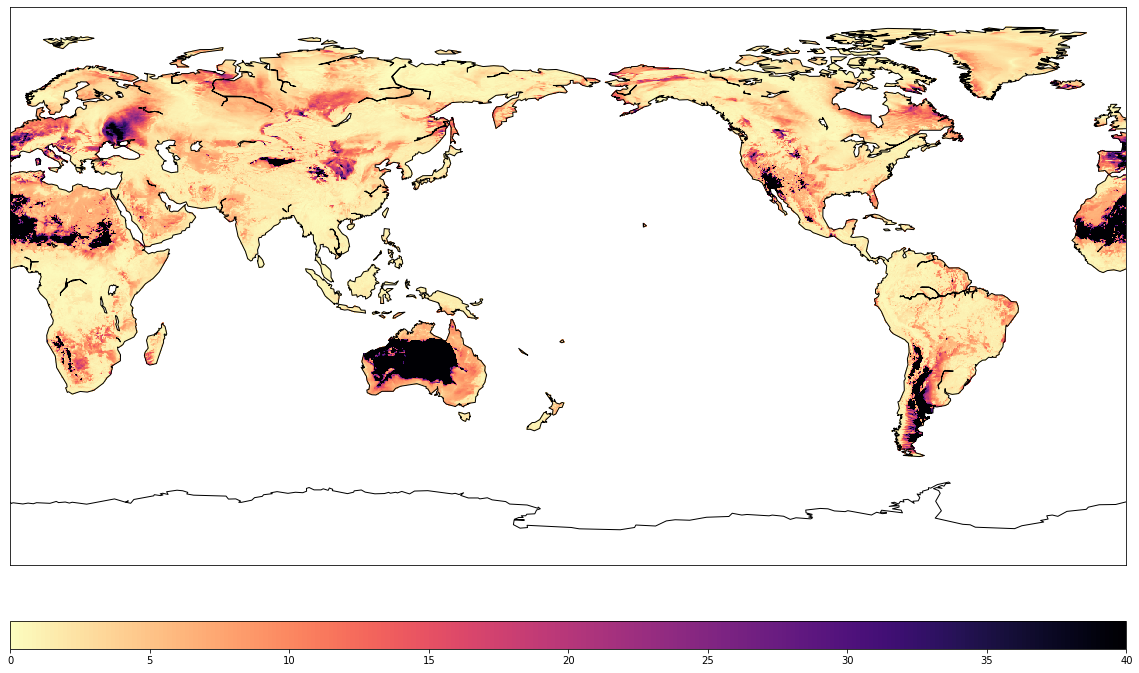

In [ ]:
plt.figure(figsize=(20, 12))

# plot coastlines
m.drawcoastlines()

# plot color scale
cmap_temp = None
#cs = m.pcolor(x, y, fwi_ths_2D)
cs = m.pcolor(x, y, np.ma.masked_where(land_map == False, fwi_ths_2D),
              vmax=40,
              cmap='magma_r')
cbar = m.colorbar(cs, location='bottom', pad="10%")

265 286
41 60


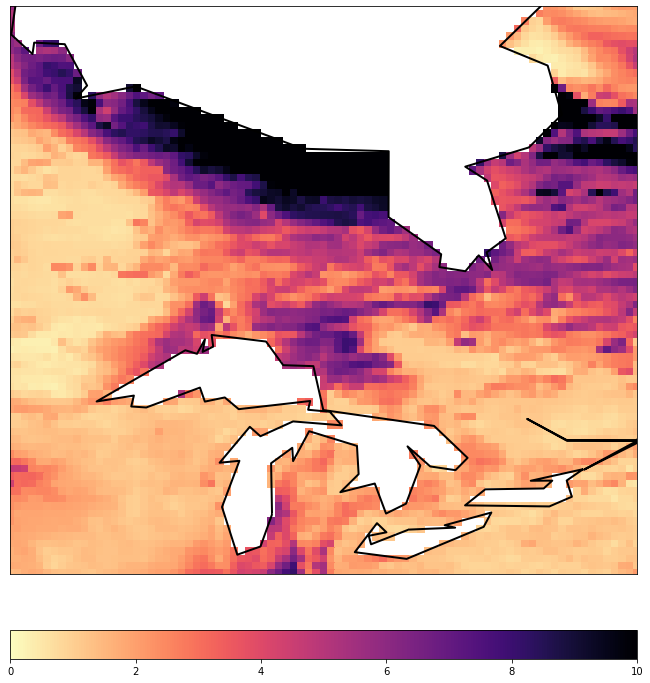

In [ ]:
plt.figure(figsize=(12, 12))

ont = Basemap(lon_0=180)

# plot coastlines
ont.drawcoastlines(linewidth=2)

# plot color scale
cmap_temp = None
#cs = m.pcolor(x, y, fwi_ths_2D)
cs = ont.pcolor(x, y, np.ma.masked_where(land_map == False, fwi_ths_2D),
              vmax=10,
              cmap='magma_r')

lllon = 360 - 95
urlon = 360 - 74
lllat = 41
urlat = 60

limits = (360 - 95, 360 - 74, 41, 60)

xmin, ymin = ont(lllon, lllat)
xmax, ymax = ont(urlon, urlat)

print(xmin, xmax)
print(ymin, ymax)

ax = plt.gca()

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

cbar = ont.colorbar(cs, location='bottom', pad="10%")